In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial
import os
from pycalphad import Database, Workspace, as_property
from pycalphad import variables as v
from pycalphad.property_framework import ReferenceState

## Relaciones termodinámicas importantes

### Energía libre de Gibbs

Se elige la energía libre de Gibbs como la función básica para el modelado termodinámico, porque si se conoce, se pueden derivar otras cantidades termodinámicas de la manera siguiente:

- Energía de Gibbs:

$$G = G\left(T,p,N_i\right)$$

- Entropía:

$$S=-\left(\frac{\partial G_m}{\partial T}\right)_{p,N_i}$$

- Entalpía:

$$H = G + TS = G - T\left(\frac{\partial G}{\partial T}\right)_{p,N_i}$$

- Volumen:

$$V = \left(\frac{\partial G}{\partial p}\right)_{T,N_i}$$

- Potencial químico del componente $i$:

$$\mu_i = \left(\frac{\partial G}{\partial N_i}\right)_{T,N_{j\ne i}}$$

- Capacidad calorífica:

$$C_p = -T \left(\frac{\partial^2 G}{\partial T^2}\right)_{p,N_i}$$

- Expansión térmica:

$$\alpha = \frac{1}{V} \left(\frac{\partial^2 G}{\partial p \partial T}\right)_{N_i}$$

- Compresibilidad isotérmica:

$$\kappa = -\frac{1}{V} \left(\frac{\partial^2 G}{\partial p^2}\right)_{T,N_i}$$

- Modulo de incompresibilidad:

$$B=\frac{1}{\kappa}$$

### Entropía configuracional

**Definición:**

La definición de entropía de Boltzmann indica la relación entre entropía ($S$) y el número de estados microscópicos ($W$) que llevan al mismo estado macroscópico:

$$S = k \cdot \ln \left(W \right)$$

Donde la constante de Boltzmann ($k$) está dada por el cociente entre la constante de los gases ($R$) y el número de Avogadro ($N_{\mathrm{A}}$):

$$k = \frac{R}{N_{\mathrm{A}}}$$

**¿Cuál sera el cambio en entropía si dos o más tipos de átomos se mezclan aleatoriamente en $N$ posiciones fijas?**

Se puede calcular considerando todas las combinaciones/arreglos posibles:

$$W = \frac{N!}{N_{1}!\cdot N_{2}!\cdots}$$


La fórmula de Stirling permite aproximar factoriales de números grandes, y en este caso aproximar las combinaciones/arreglos posibles:

$$\ln \left(N!\right) \approx N \cdot \ln\left(N\right) - N$$

Notese que conforme el valor de $N$ incrementa, la aproximación es buena, aún si se desprecia el segundo término de la fórmula de Stirling:

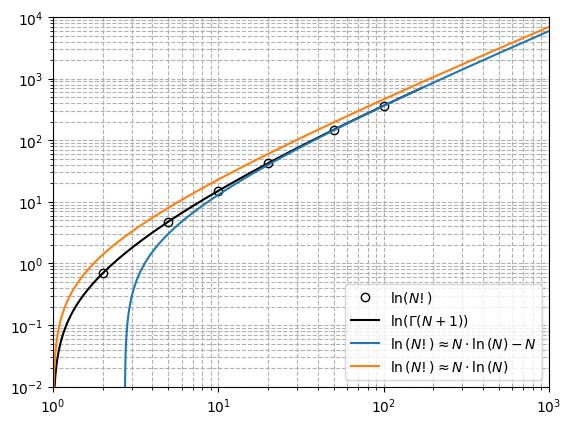

In [3]:
fig, ax = plt.subplots()
ints = np.array([2, 5, 10, 20, 50, 100])
N = np.logspace(0, 3, 1000)
ax.plot(ints, np.log(factorial(ints)), ls='', marker='o', c='k', mfc="None", label=r'$\ln(N!)$')
ax.plot(N, np.log(gamma(N+1)), c='k', label=r"$\ln(\Gamma(N+1))$")
ax.plot(N, N*np.log(N)-N, label=r"$\ln \left(N!\right) \approx N \cdot \ln\left(N\right) - N$")
ax.plot(N, N*np.log(N), label=r"$\ln \left(N!\right) \approx N \cdot \ln\left(N\right)$")

ax.set_ylim(1e-2, 1e4)
ax.set_yscale('log')
ax.set_xlim(1e0, 1e3)
ax.set_xscale('log')
ax.legend(loc='lower right')
ax.grid(ls='--', which='both')
plt.show()

Aproximando $W$ mediante la fórmula de Stirling, y despreciando el segundo término del lado derecho, se tiene:

$$k \ln \left( W \right) = k \cdot \left[ N \cdot \ln (N) - N_A \cdot \ln (N_A) - N_B \cdot \ln (N_B) - \cdots\right]$$

Multiplicando el lado derecho por $N/N$, identificando que $N_{1}/N, N_{2}/N, \cdots$, corresponde a las fracciones molares $x_{1}, x_{2}, \cdots$, y sustituyendo el número de Avogadro en $N$, se obtiene la fórmula típica para la entropía configuracional:

$$k \cdot \ln(W) \approx -R \cdot \left(x_1 \cdot \ln (x_1) + x_2 \cdot \ln (x_2) + \cdots \right)$$

### Relaciones adicionales para termodinámica de soluciones

**Energía libre de Gibbs por mol de unidad de fórmula:**

Para el modelado de soluciones se utiliza la energía libre de Gibbs por mol de unidad de fórmula

$$G_m = \frac{G}{N}$$

**Energía molar parcial:**

La energía molar parcial para el componente $i$ se define como:

$$G_i = \left( \frac{\partial G}{\partial N_i} \right)_{T,p,N_{j \ne i}}$$

Expresada como una función de fracciones molares, se escribe como:

$$G_i = G_m + \left( \frac{\partial G_m}{\partial x_i} \right)_{T,P,x_k} - \sum_j x_j \left( \frac{\partial G_m}{\partial x_j} \right)_{T,p,x_l}$$

$$\left(k \ne i, l \ne j \right)$$

Bajo condiciones de presión constante el potencial químico, y la energía molar parcial de Gibbs son equivalentes:

$$\mu_i = \left(\frac{\partial G}{\partial N_i}\right)_{T,N_{j\ne i}}$$

$$G_i = \left( \frac{\partial G}{\partial N_i} \right)_{T,p,N_{j \ne i}}$$

$$\left. \mu_i \right|_p \equiv G_i$$

## Minimización de la energía de Gibbs

**Energía total de Gibbs:**

La energía total de Gibbs, $G$, se calcula como la suma de las energías integrales molares de Gibbs de cada fase, $G_m^{\alpha}$, multiplicado por la fracción o la cantidad de cada fase, $m^{\alpha}$:

$$G = \sum_{\alpha} m^{\alpha} \cdot G_m^{\alpha}$$

$$m^{\alpha} \ge 0$$

**Energía integral molar de Gibbs**:

En su forma más simple, se expresa como una función de la temperatura ($T$), presión ($p$), y fracciones molares de constituyentes en las fases ($x_i^{\alpha}$):

$$G_m^{\alpha} = G_m^{\alpha} \left(T, p, x_i^{\alpha} \right)$$

En modelos de que consideran subredes, la cantidad de constituyentes en las fases se contabiliza mediante la fracción 
($y_k^{(l,\alpha)}$) de sitios ocupados por el constiyente $k$ en la subred $l$ en la fase $\alpha$:

$$G_m^{\alpha} = G_m^{\alpha} \left(T, p, y_k^{(l,\alpha)} \right)$$

**Regla de la palanca generalizada:**

La fracción molar global de un componente $i$ en un sistema, $x_i$, debe ser igual a la suma sobre todas las fases en equilibrio de la cantidad de fase estable, $m^{\alpha}$, multiplicada por la fracción molar del componente $i$ presente en dicha fase, $x_i^{\alpha}$. 

$$x_i = \sum_{\alpha} m^{\alpha} \cdot x_i^{\alpha}$$

**Condición de equilibrio:**

El sistema está en equilibrio cuando la energía total de Gibbs se encuentra en su mínimo global:


$$\min\left(G\right) = \min \left( \sum_{\alpha} m^{\alpha} \cdot G_m^{\alpha} \left(T, p, \left\{x_i^{\alpha} \vee y_k^{(l,\alpha)} \right\} \right) \right)$$

Las variables $m^{\alpha}$, y $x_i^{\alpha} \vee y_{k}^{l,\alpha}$, generalmente son desconocidas, y sus valores se deben calcular a partir de las condiciones de mínimo energético.


## Modelos para la energía libre de Gibbs

### Expresión general

**Expresión general:**

La energía libre total de Gibbs para una fase $\theta$ se expresa como:

$$G_m^{\theta} = {}^{\text{srf}}G_m^{\theta} + {}^{\text{phys}}G_m^{\theta} - T \cdot {}^{\text{cnf}}S_m^{\theta} + {}^{\text{E}}G_m^{\theta}$$

- **${}^{\text{srf}}G_m^{\theta}$**: Energía de Gibbs de la mezcla de los constituyentes (de la fase) *sin reaccionar*.

- **${}^{\text{phys}}G_m^{\theta}$**: Contribuciones debido a procesos físicos, e.g., transiciones magnéticas, presión, etc.

- **${}^{\text{cnf}}S_m^{\theta}$**: Entropía configuracional.

- **${}^{\text{E}}G_m^{\theta}$**: Energía de Gibbs en exceso.

### Elementos puros

Para elementos puros, la energía libre tiene las contribuciones de la superficie de referencia (${}^{\text{srf}}$), y de otros efectos físicos sobre cada fase tales como transiciones magnéticas (${}^{\text{mag}}$) o efectos de la presión (${}^{\text{pres}}$).

$$G_m^{\theta} = {}^{\text{srf}}G_m^{\theta} + {}^{\text{phys}}G_m^{\theta}$$

$${}^{\text{phys}}G_m^{\theta} = {}^{\text{mag}}G_m^{\theta} + {}^{\text{pres}}G_m^{\theta}$$

La energía para la superficie de referencia se representa mediante una serie de potencias con respecto a la temperatura:

$${}^{\text{srf}}G_m^{\theta} -  H_i^{\text{SER}} = a_0 + a_1 T + a_2 T \ln(T) + a_3 T_2 + a_4 T^{-1} + a_5 T^{3} + \cdots; \quad \quad T_1 < T < T_2$$

#### Ejemplo

Definición de la energía libre del aluminio en una [base de datos termodinámica](https://www.sgte.net/en/free-pure-elements-database).

$$G_m^{\mathrm{Al,FCC}} - H_{\mathrm{Al}}^{\text{SER}} = a_0 + a_1 T + a_2 T \ln(T) + a_3 T_2 + a_4 T^{-1} + a_5 T^{3} + \cdots$$

$$G_m^{\mathrm{Al,LIQ}} - H_{\mathrm{Al}}^{\text{SER}} = G_m^{\mathrm{Al,FCC}} + a_0 + a_1 T + a_2 T \ln(T) + a_3 T_2 + a_4 T^{-1} + a_5 T^{3} + \cdots$$

<details>
<summary><b>Ejemplo: Base de datos termodinámicos Aluminio</b></summary>

<div class="alert alert-info">

```TDB
$ MODED from: Version 5.0 of Unary database - 2 June 2009
$ TITLE=SGTE Unary Database version v5.0 - 2 June 2009
$ https://www.sgte.net/en/free-pure-elements-database
$                                      mw[g/mol]   H298[J/mol] S298[J/(mol.K)]
 ELEMENT VA   VACUUM                    0.0000E+00  0.0000E+00  0.0000E+00!
 ELEMENT AL   FCC_A1                    2.6982E+01  4.5773E+03  2.8322E+01!

 TYPE_DEFINITION % SEQ *!
 DEFINE_SYSTEM_DEFAULT SPECIE 2 !
 DEFAULT_COMMAND DEF_SYS_ELEMENT VA /- !

 FUNCTION GHSERAL   298.15 
    -7976.15+137.093038*T-24.3671976*T*LN(T)
     -.001884662*T**2-8.77664E-07*T**3+74092*T**(-1);              700 Y
     -11276.24+223.048446*T-38.5844296*T*LN(T)+.018531982*T**2
     -5.764227E-06*T**3+74092*T**(-1);                          933.47 Y
     -11278.361+188.684136*T-31.748192*T*LN(T)
     -1.230622E+28*T**(-9);                                      2900 N!

 FUNCTION GLIQAL   298.15 
    +GHSERAL#+11005.045-11.84185*T+7.9337E-20*T**7;             933.47 Y
      -795.991+177.430209*T-31.748192*T*LN(T);                  2900 N !

 PHASE LIQUID:L %  1  1.0  !
 CONSTITUENT LIQUID:L :AL,SI :  !
   PARAMETER G(LIQUID,AL;0)    298.15 +GLIQAL#;                2900.00 N!

 PHASE FCC_A1 % 1  1  !
 CONSTITUENT FCC_A1 : AL :!
   PARAMETER G(FCC_A1,AL;0)    298.15  +GHSERAL#;              2900.00 N!       
```

</div>

</details>

In [4]:
# Definicion de base de datos, componentes, fases, condiciones
tdbpath = os.path.join("TDB", "SGTE-unary1991-2010.TDB")
tdb = Database(tdbpath)
comps = ['AL', 'VA']
phases = ['FCC_A1', 'LIQUID']
conditions = {v.T:(273, 1273, 1), v.P: 1e5, v.N: 1}
# Creacion de espacio de trabajo
wks = Workspace(database = tdb, components = comps, phases = phases, conditions = conditions)

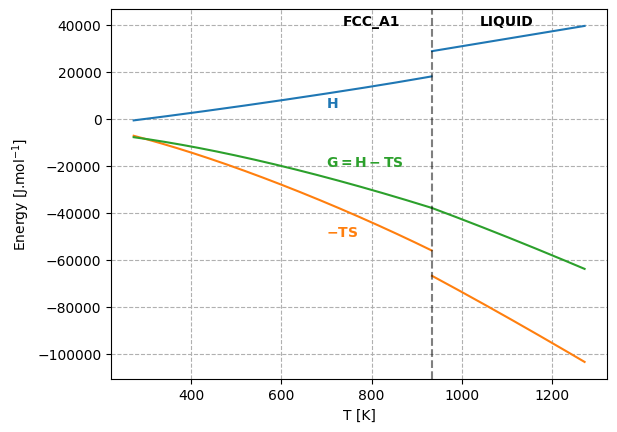

In [5]:
fig, ax = plt.subplots()
T = wks.get(v.T)
for phase in wks.phases:
    H = wks.get(f"HM({phase})") # entalpía molar [J/mol]
    S = wks.get(f"SM({phase})") # entropía molar [J/(mol.K)]
    G = wks.get(f"GM({phase})") # energía libre molar [J/mol]
    ax.plot(T, H, color='C0')
    ax.plot(T, -T*S, color='C1')
    ax.plot(T, G, color='C2')
ax.axvline(x=933.47, ls='--', color='k', alpha=0.5)
ax.annotate(r"$\mathbf{H}$", xy=(700, 5e3), color='C0')
ax.annotate(r"$\mathbf{-T S}$", xy=(700, -5e4), color='C1')
ax.annotate(r"$\mathbf{G=H-TS}$", xy=(700, -2e4), color='C2')
ax.annotate(r"FCC_A1", xy=(800, 4e4), weight='bold', ha='center')
ax.annotate(r"LIQUID", xy=(1100, 4e4), weight='bold', ha='center')
ax.set_xlabel("T [K]")
ax.set_ylabel(r"Energy [J.mol$^{-1}$]")
ax.grid(ls='--')
plt.show()

Otras funciones termodinámicas se pueden calcular directamente, manipulando la serie de potencias conforme a relaciones termodinámicas existentes:


**Entalpía:**

$$H = G + TS = G - T\left(\frac{\partial G}{\partial T}\right)_{p,N_i}$$

$$H_m^{\theta} - H^{\text{SER}} = a_0 - a_2 T - a_3 T^2 + 2 a_4 T^{-1} - 2 a_5 T^3 \cdots$$

**Entropía:**

$$S=-\left(\frac{\partial G_m}{\partial T}\right)_{p,N_i}$$

$$S_m^{\theta} = -a_1 - a_2\left(1 + \ln(T)\right) - 2 a_3 T + a_4 T^{-2} - 3 a_5 T^2 \cdots$$

**Capacidad calorífica:**

$$C_p = -T \left(\frac{\partial^2 G}{\partial T^2}\right)_{p,N_i}$$

$$C_P^{\theta} = -a_2 - 2 a_3 T - 2 a_4 T^{-2} - 6 a_5 T^{2} \cdots$$


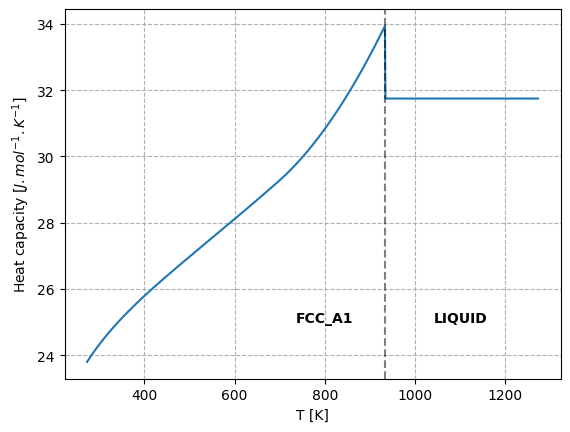

In [6]:
# Obtener datos a partir del espacio de trabajo
T = wks.get(v.T)
heat_capacity = as_property("HM.T")
Cp = wks.get(heat_capacity)
# graficar propiedad
fig, ax = plt.subplots()
ax.plot(T, Cp)
ax.axvline(x=933.47, ls='--', color='k', alpha=0.5)
ax.annotate(r"FCC_A1", xy=(800, 25), weight='bold', ha='center')
ax.annotate(r"LIQUID", xy=(1100, 25), weight='bold', ha='center')
ax.set_xlabel("T [K]")
ax.set_ylabel(r"Heat capacity [$J.mol^{-1}.K^{-1}$]")
ax.grid(ls='--')
plt.show()

### Fases con composición fija

Generalmente, la energía molar de Gibbs, $G_m$, de un miembro final estable de una fase $\theta$, se describe mediante una serie de potencias con respecto a la temperatura:

$$G_m^{\theta} - \sum_i b_i H_i^{\text{SER}} = a_0 + a_1 T + a_2 T \ln(T) + a_3 T_2 + a_4 T^{-1} + a_5 T^{3} + \cdots; \quad \quad T_1 < T < T_2$$

#### Ejemplo

Definición de la energía libre de la $\text{Cementita}$ en una [base de datos termodinámica](https://doi.org/10.1016/j.calphad.2010.01.004).

$$G_m^{\mathrm{Fe_3C}} = {}^{\text{srf}}G_m^{\mathrm{Fe_3C}} + {}^{\text{mag}}G_m^{\mathrm{Fe_3C}}$$

$${}^{\text{srf}}G_m^{\mathrm{Fe_3C}} - 3H_{\mathrm{Fe}}^{\text{SER}} - H_{\mathrm{C}}^{\text{SER}} = a_0 + a_1 T + a_2 T \ln(T) + a_3 T_2 + a_4 T^{-1} + a_5 T^{3} + \cdots$$

$${}^{\text{mag}}G_m^{\mathrm{Fe_3C}} = nRTf(\tau) \ln\left(\beta + 1\right)$$

$$\tau = \frac{T}{T_C}$$

<details>
<summary><b>Ejemplo: Base de datos termodinámicos Cementita</b></summary>

<div class="alert alert-info">

```TDB
$
$ https://pycalphad.org/docs/latest/examples/CementiteAnalysis.html
$
$ B Hallstedt, D Djurovic, J von Appen, R Dronskowski, 
$ A Dick, F Körmann, T Hickel, J Neugebauer, 
$ "Thermodynamic properties of cementite", 
$ Calphad, Volume 34, Issue 1, March 2010, 
$ Pages 129-133, ISSN 0364-5916, 
$ http://dx.doi.org/10.1016/j.calphad.2010.01.004. 
$ (http://www.sciencedirect.com/science/article/pii/S0364591610000052)
$
$                                      mw[g/mol]   H298[J/mol] S298[J/(mol.K)]
 ELEMENT C    GRAPHITE                   12.011     1054.0      5.7423 !
 ELEMENT FE   BCC_A2                     55.847     4489.0     27.2797 !

 TYPE_DEFINITION % SEQ * !

 FUNCTION GFECEM      0.01  
   +11369.937746-5.641259263*T-8.333E-6*T**4;                   43.00  Y 
   +11622.647246-59.537709263*T+15.74232*T*LN(T)-0.27565*T**2; 163.00  Y  
   -10195.860754+690.949887637*T-118.47637*T*LN(T)
            -0.0007*T**2+590527*T**(-1);                    6000.00  N !

 TYPE_DEFINITION A GES AMEND_PHASE_DESCRIPTION @ MAGNETIC -3 0.28 !
 PHASE CEMENTITE_D011 %A 2 3 1 !
 CONSTITUENT CEMENTITE_D011 : FE : C : !
 PARAMETER  G(CEMENTITE_D011,FE:C;0) 0.01 +GFECEM; 6000 N !
 PARAMETER  TC(CEMENTITE_D011,FE:C;0) 0.01 485.00; 6000 N !
 PARAMETER  BMAGN(CEMENTITE_D011,FE:C;0) 0.01 1.008; 6000 N !

```

</div>

</details>

In [7]:
# Definicion de base de datos, componentes, fases, condiciones
tdbpath = os.path.join("TDB", "cementite.TDB")
tdb = Database(tdbpath)
comps = ['FE', 'C']
phases = ['CEMENTITE_D011']
conditions = {v.N: 1, v.P: 1e5, v.T: (1, 700, 0.5), v.X('C'): 0.25}
# Creacion de espacio de trabajo
wks = Workspace(database = tdb, components = comps, phases = phases, conditions = conditions)

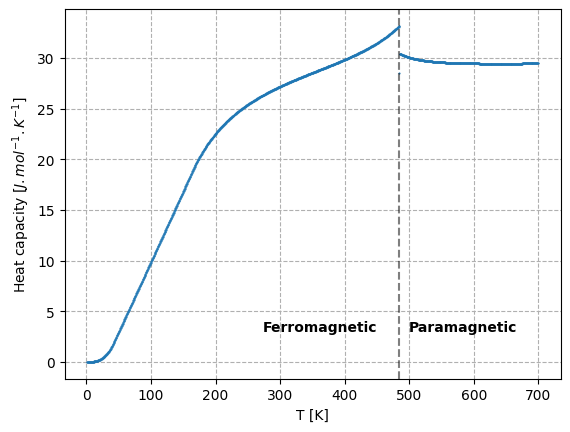

In [8]:
# Obtener datos a partir del espacio de trabajo
T = wks.get(v.T)
heat_capacity = as_property("HM.T")
Cp = wks.get(heat_capacity)
# graficar propiedad
fig, ax = plt.subplots()
ax.plot(T, Cp, marker='.', ms=1, ls='')
ax.axvline(x=485, ls='--', c='k', alpha=0.5)
ax.annotate(r"Ferromagnetic", xy=(450, 3), weight='bold', ha='right')
ax.annotate(r"Paramagnetic", xy=(500, 3), weight='bold', ha='left')
ax.set_xlabel("T [K]")
ax.set_ylabel(r"Heat capacity [$J.mol^{-1}.K^{-1}$]")
ax.grid(ls='--')
plt.show()

### Soluciones

$$G_m^{\theta} = \underbrace{{}^{\text{srf}}G_m^{\theta} - T \cdot {}^{\text{cnf}}S_m^{\theta}}_{\text{ideal}} + \underbrace{{}^{\text{E}}G_m^{\theta}}_{\text{exceso}}  + \cancel{ {}^{\text{phys}}G_m^{\theta}} $$

$$G_m^{\theta} = \underbrace{\sum_{i=1}^{n} x_i \cdot {}^{\text{srf}}G_{i,\theta} + RT \cdot \sum_{i=1}^{n} x_i \ln(x_i) }_{\text{ideal}}  + \underbrace{\sum_{i} \sum_{j>i} x_i x_j L_{i,j}^{\theta}}_{\text{exceso}} + \cancel{ {}^{\text{phys}}G_m^{\theta}} $$

$$L_{i,j}^{\theta} = \sum_{\nu=0}^{k} \left(x_i - x_j\right)^{\nu} \cdot {}^{^{\nu}}L_{i,j}^{\theta}$$

$${}^{^{\nu}}L_{i,j}^{\theta} = L_0 + L_1 T + \cdots$$

#### Ejemplo

Definición de la energía libre de un fase líquida en el sistema $\text{Al-Si}$ en una [base de datos termodinámica](https://www.opencalphad.com/databases/CGNA18499ENC_001.pdf).

$$G_m^{\mathrm{LIQ}} = \underbrace{x_{\mathrm{Al}}  \cdot {}^{\circ}G_{\mathrm{Al}}^{\mathrm{LIQ}} + x_{\mathrm{Si}}  \cdot {}^{\circ}G_{\mathrm{Si}}^{\mathrm{LIQ}} + RT \left( x_{\mathrm{Al}} \ln  x_{\mathrm{Al}} + x_{\mathrm{Si}} \ln  x_{\mathrm{Si}}\right) }_{\text{ideal}} + $$

$$ \underbrace{x_{\mathrm{Al}} \cdot x_{\mathrm{Si}} \cdot {}^{^{0}}L_{\mathrm{Al,Si}}^{\mathrm{LIQ}} + x_{\mathrm{Al}} \cdot x_{\mathrm{Si}} \cdot \left( x_{\mathrm{Al}} - x_{\mathrm{Si}} \right) \cdot {}^{^{1}}L_{\mathrm{Al,Si}}^{\mathrm{LIQ}} + x_{\mathrm{Al}} \cdot x_{\mathrm{Si}} \cdot \left( x_{\mathrm{Al}} - x_{\mathrm{Si}} \right)^2 \cdot {}^{^{2}}L_{\mathrm{Al,Si}}^{\mathrm{LIQ}}}_{\text{exceso}}$$

$${}^{^{0}}L_{\mathrm{Al,Si}}^{\mathrm{LIQ}} = -11340.1 - 1.23394 T$$

$${}^{^{1}}L_{\mathrm{Al,Si}}^{\mathrm{LIQ}} = -3530.93 + 1.35993 T$$

$${}^{^{2}}L_{\mathrm{Al,Si}}^{\mathrm{LIQ}} = 2265.39 T$$

<details>
<summary><b>Ejemplo: Base de datos termodinámicos Al-Si</b></summary>

<div class="alert alert-info">

```TDB
$  'COST (1998): COST 507 -- Definition of Thermochemical and 
$    Thermophysical Properties to Provide a Database for the Development 
$    of New Light Alloys. European Cooperation in the Field of 
$    Scientific and Technical Research, European Commission. Vol 1. 
$    Proceedings of the Final Workshop of COST 507, Vaals, the 
$    Netherlands, 1997; Vol 2. 
$
$                                      mw[g/mol]   H298[J/mol] S298[J/(mol.K)]
 ELEMENT VA   VACUUM                    0.0000E+00  0.0000E+00  0.0000E+00!
 ELEMENT AL   FCC_A1                    2.6982E+01  4.5773E+03  2.8322E+01!
 ELEMENT SI   DIAMOND_A4                2.8085E+01  3.2175E+03  1.8820E+01!

 TYPE_DEFINITION % SEQ *!
 DEFINE_SYSTEM_DEFAULT ELEMENT 2 !
 DEFAULT_COMMAND DEF_SYS_ELEMENT VA /- !

 TYPE_DEFINITION % SEQ * !

 FUNCTION GHSERAL   298.15 
    -7976.15+137.093038*T-24.3671976*T*LN(T)
     -.001884662*T**2-8.77664E-07*T**3+74092*T**(-1);              700 Y
     -11276.24+223.048446*T-38.5844296*T*LN(T)+.018531982*T**2
     -5.764227E-06*T**3+74092*T**(-1);                          933.47 Y
     -11278.361+188.684136*T-31.748192*T*LN(T)
     -1.230622E+28*T**(-9);                                      2900 N!

 FUNCTION GLIQAL   298.15 
    +GHSERAL#+11005.045-11.84185*T+7.9337E-20*T**7;             933.47 Y
      -795.991+177.430209*T-31.748192*T*LN(T);                  2900 N !

 FUNCTION GHSERSI   298.15 
    -8162.609+137.236859*T-22.8317533*T*LN(T)
     -.001912904*T**2-3.552E-09*T**3+176667*T**(-1);              1687 Y
     -9457.642+167.281367*T-27.196*T*LN(T)-4.20369E+30*T**(-9); 3600 N !

 FUNCTION GLIQSI    298.15 
    +GHSERSI#+50696.36-30.099439*T+2.09307E-21*T**7;              1687 Y
      +40370.523+137.722298*T-27.196*T*LN(T);                   3600 N !      


 PHASE LIQUID:L %  1  1.0  !
 CONSTITUENT LIQUID:L :AL,SI :  !
   PARAMETER G(LIQUID,AL;0)    298.15 +GLIQAL#;                2900.00 N !
   PARAMETER G(LIQUID,SI;0)    298.15 +GLIQSI#;                3600.00 N !
   PARAMETER G(LIQUID,AL,SI;0) 298.15 -11340.1-1.23394*T;      6000.00 N !
   PARAMETER G(LIQUID,AL,SI;1) 298.15 -3530.93+1.35993*T;      6000.00 N !
   PARAMETER G(LIQUID,AL,SI;2) 298.15 +2265.39;                6000.00 N !

```

</div>

</details>

In [42]:
# Definicion de base de datos, componentes, fases, condiciones
tdbpath = os.path.join("TDB", "AlSi98.TDB")
tdb = Database(tdbpath)
comps = ['Al', 'SI', 'VA']
phases = ['LIQUID']
conditions = {v.N: 1, v.P: 1e5, v.T: 1000, v.X('SI'): (0, 1, 0.01)}
# Creacion de espacio de trabajo
wks = Workspace(database = tdb, components = comps, phases = phases, conditions = conditions)
# Creacion de estado de referencia
ref = ReferenceState([
    ("LIQUID", {v.X("SI"): 0, v.T: 1000.0}), # Al(Liq, 1000K)
    ("LIQUID", {v.X("SI"): 1, v.T: 1000.0})  # Si(Liq, 1000K)
    ], wks
)

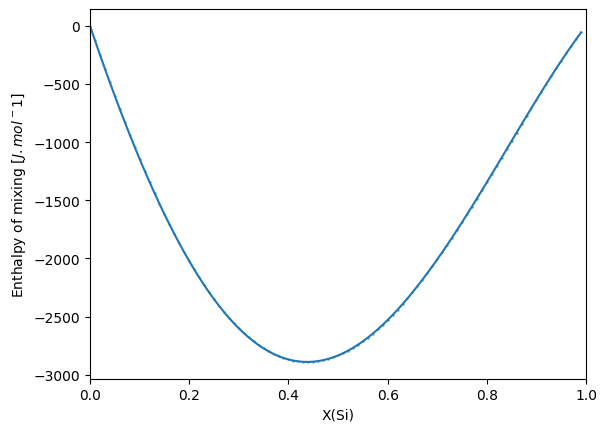

In [ ]:
x_si, mixing_enthalpy = wks.get(v.X('SI'), ref('HM'))
# graficar entalpia de mezclado
fig, ax = plt.subplots()
unique_phase_sets = np.unique(wks.eq.Phase.squeeze(), axis=0)
for phase_set in unique_phase_sets:
    label = '+'.join([ph for ph in phase_set if ph != ''])
    # composition indices with the same stable set of phases
    unique_phase_idx = np.nonzero(np.all(wks.eq.Phase.squeeze() == phase_set, axis=1))[0]
    ax.plot(x_si[unique_phase_idx], mixing_enthalpy[unique_phase_idx], marker='.', ms=1)
ax.set_xlim((0, 1))
ax.set_xlabel(f'X(Si)')
ax.set_ylabel(f'Enthalpy of mixing [$J.mol^{-1}$]')
ax.grid(ls='--')
plt.show()

## Referencias

### Bibliografía

H.L. Lukas, S.G. Fries, B. Sundman  
**Computational Thermodynamics: The Calphad Method**  
Cambridge University Press (2007)  
DOI: [https://doi.org/10.1017/CBO9780511804137](https://doi.org/10.1017/CBO9780511804137)

A Dinsdale  
**SGTE Data for Pure Elements**  
Calphad, Volume 15 (1991), pp. 317-425  
DOI: [https://doi.org/10.1016/0364-5916(91)90030-N](https://doi.org/10.1016/0364-5916(91)90030-N)

B. Hallstedt, D. Djurovic, J. von Appen, R. Dronskowski, A. Dick, F. Körmann, T. Hickel, J. Neugebauer   
**Thermodynamic properties of cementite**  
Calphad, Volume 34 (2010), pp. 129-133   
DOI:[https://doi.org/10.1016/j.calphad.2010.01.004](https://doi.org/10.1016/j.calphad.2010.01.004)

I.Ansara, A.T. Dinsdale, M.H. Rand (eds.)  
**COST 507 Thermochemical database for light metal alloys, Volume 2**  
EUR 18499 EN (July 1998)  
ISBN: 92-828-3902-8  
URL: [https://www.opencalphad.com/databases/CGNA18499ENC_001.pdf](https://www.opencalphad.com/databases/CGNA18499ENC_001.pdf)

### Web

A Kajinic  
**CALPHAD Method**  
Visited on: 2025-11-06  
URL: [https://calphad.com/calphad_method/](https://calphad.com/calphad_method/)


A Dinsdale  
**SGTE Pure Element Database (UNARY)**  
Visited on: 2025-11-06  
URL: https://www.sgte.net/en/free-pure-elements-database